# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [12]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

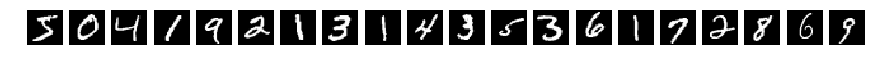

In [13]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [15]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [23]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


#Softmax 1-D
#Input : v(1,c) - vector from liniar classifier used on 1 sample
#Output: probabilities of every class for sample pr(1,c)
# Modifications: Numerical stability. Normalizaion for (potentially) large numbers used
def softmax(z):
    ########################################
    # TODO: implement the softmax function #
    ########################################
    z -= np.max(z)
    exp = np.exp(z)
    return exp/np.sum(exp)


#Predict: 
# m -number of samples
# f - number of features
# c - number of classes (we have digits, so we have 10 classes)
#Input :w(784,c), X(m,f)
#1)Dot product of X and w -> (m,c) - For every example we have classifier output (1,c)
#2)Compute probabilities using softmax. softmax(M(m,c)) -> prob(m,c) - for every sample 
#  we have probability(1,10) of being of the class
#Output: (m,c)
def predict(w, X):
    ###################################
    # TODO: compute the probabilities #
    ###################################
    M = np.dot(X,w)
    return np.apply_along_axis(softmax, axis=1, arr=M)

def compute_loss_and_gradients(weights, X, y, l2_reg):
    #############################################################################
    # TODO: compute loss and gradients, don't forget to include regularization! #
    #############################################################################
    n_samples = X.shape[0]
    pred = predict(weights,X)
    y_arr  = y.argmax(axis=1)
    prob = pred[range(n_samples),y_arr]
    
    loss = -(np.sum(np.log(prob))) + l2_reg * np.sum(weights **2)
    
    grad = pred.copy()
    grad[range(n_samples),y_arr] -= 1
    grad = grad/n_samples
    grad = X.T.dot(grad)
    grad -= 2 * l2_reg * weights
    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

In [ ]:
l2_reg = 0.5
n_epochs = 250
lr = 0.05

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [17]:
##############################
# TODO: compute the accuracy #
##############################
def accuracy(X,ground_truth):
    pred = predict(weights,X)
    return np.mean(pred.argmax(axis=1) == ground_truth.argmax(axis=1))
    
print("Training accuracy", accuracy(x_train,y_train))
print("Test accuracy", accuracy(x_test,y_test))

Training accuracy 0.09871666666666666
Test accuracy 0.098


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


Training accuracy 0.8700166666666667
Test accuracy 0.8766


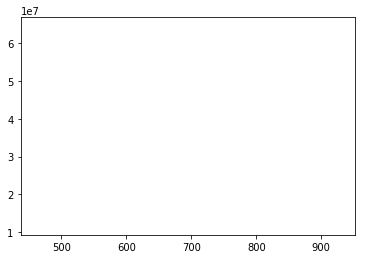

In [26]:
l2_reg = 0.01
lr = 0.09
losses = []
epochs= 2
batch_size = 128
n_epochs = x_train.shape[0]//batch_size

for j in range(epochs):
    for i in range(n_epochs):
        p = i * batch_size
        q = p+batch_size
        loss, grad = compute_loss_and_gradients(weights, x_train[p:q], y_train[p:q], l2_reg)
        losses.append(loss)
        weights -= lr * grad

plt.plot(losses)

print("Training accuracy", accuracy(x_train,y_train))
print("Test accuracy", accuracy(x_test,y_test))

In [ ]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [ ]:
################################################
# TODO: implement the proper training pipeline #
################################################

Training pipeline<br/>
1)Upload data. X and y<br/>
2)Make train, test sets<br/>
2.5)? Is cross-validation needed?<br/>
3)create object of linear optimizer<br/>
4)Grid_search on perameters<br/>
5)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [2]:
from sft_regr import softmax_regression
sft = softmax_regression()

In [3]:
sft.fit(x_train,y_train)

In [5]:
sft.train(epochs = 1)

In [10]:
prediction =  sft.predict(x_test)
accuracy(prediction,y_test)

0.8953